<a href="https://www.kaggle.com/code/mikedelong/la-crime-eda-with-map?scriptVersionId=248990048" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
df = pd.read_csv(filepath_or_buffer='/kaggle/input/los-angeles-crime-dataset-2020-present/Crime_Data_from_2020_to_Present.csv', 
                 parse_dates=['Date Rptd', 'DATE OCC']).drop(columns=['DR_NO'])
df.sample(n=7)

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
580985,2022-05-08,2022-05-08,1909,18,Southeast,1831,1,310,BURGLARY,1607 1822 0321 0329 0342 0344 1300 0216,...,IC,Invest Cont,310.0,NaN,NaN,NaN,700 W 124TH ST,NaN,33.9201,-118.2870
494013,2022-02-10,2022-02-09,2100,2,Rampart,245,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),1300 0344 1402 1822 0385 1608,...,IC,Invest Cont,420.0,998.0,NaN,NaN,500 S CORONADO ST,NaN,34.0632,-118.2796
51332,2020-06-30,2020-06-29,2200,11,Northeast,1145,1,330,BURGLARY FROM VEHICLE,0344,...,IC,Invest Cont,330.0,NaN,NaN,NaN,2400 SILVER RIDGE AV,NaN,34.0997,-118.2555
496736,2022-12-24,2022-12-23,1900,19,Mission,1902,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329 1822,...,IC,Invest Cont,740.0,NaN,NaN,NaN,14300 FOOTHILL BL,NaN,34.3192,-118.4455
625637,2022-11-28,2022-11-28,700,12,77th Street,1255,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,0329 0913 0421 2038,...,IC,Invest Cont,930.0,NaN,NaN,NaN,1000 W FLORENCE AV,NaN,33.9746,-118.2917
87519,2020-02-07,2020-02-06,1800,10,West Valley,1061,1,310,BURGLARY,1609 0321 1307 1822,...,IC,Invest Cont,310.0,NaN,NaN,NaN,19200 VENTURA BL,NaN,34.1726,-118.5517
189317,2020-06-21,2020-06-21,2100,16,Foothill,1663,2,753,DISCHARGE FIREARMS/SHOTS FIRED,1100 1407,...,IC,Invest Cont,753.0,998.0,NaN,NaN,TRUESDALE ST,ONEIDA AV,34.2373,-118.4035


In [2]:
df.columns.to_frame().T

,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON
0,Date Rptd,DATE OCC,TIME OCC,AREA,AREA NAME,Rpt Dist No,Part 1-2,Crm Cd,Crm Cd Desc,Mocodes,...,Status,Status Desc,Crm Cd 1,Crm Cd 2,Crm Cd 3,Crm Cd 4,LOCATION,Cross Street,LAT,LON


Let's look at some distributions; we'll look at victim age first, and we need to filter out Age == 0 for unknown ages.

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Vict Age', ylabel='Count'>

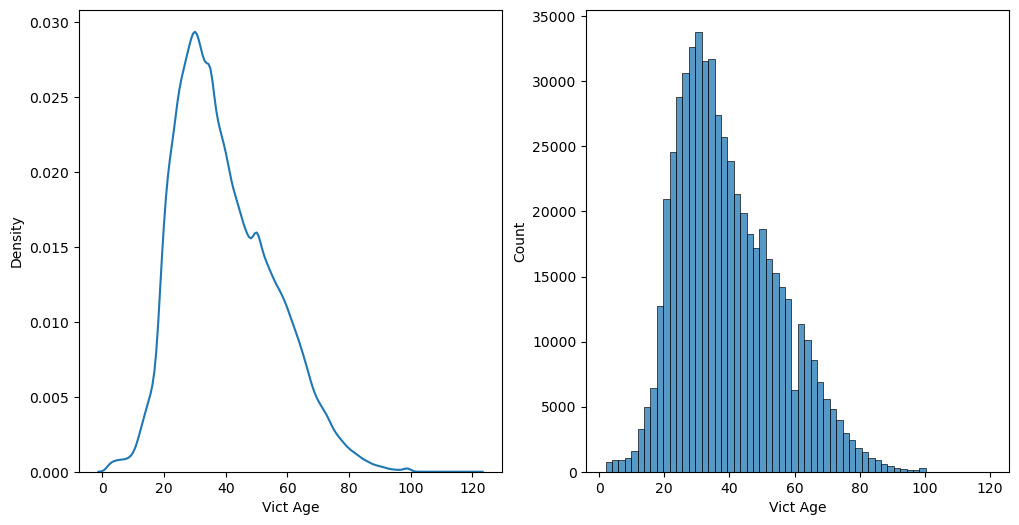

In [3]:
%matplotlib inline
from seaborn import kdeplot
from seaborn import histplot
import matplotlib.pyplot as plt

_, ax = plt.subplots(figsize=(12, 6), ncols=2)
kdeplot(ax=ax[0], data=df[df['Vict Age'] > 0], x='Vict Age') 
histplot(ax=ax[1], data=df[df['Vict Age'] > 0], x='Vict Age', bins=60)

Next let's visualize a small sample on an interactive map using Folium.

In [4]:
from folium import Icon
from folium import Map
from folium import Marker

sample_size = 1000

# we have a limited color map so we loop it to pad it out
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple',
          'white', 'pink', 'lightblue', 'lightgreen', 'gray', 'black', 'lightgray'] * 7
code_color_map = dict(zip(tuple(df['Crm Cd'].unique()), tuple(colors)))

# for some reason we have to fudge the center a little
lon_fudge = -0.5
location_map = Map(location=[df['LAT'].mean(), df['LON'].mean() + lon_fudge], zoom_start=10.5)
for index, row in df.sample(sample_size).iterrows():
    popup = '{}/{}/{}:{}'.format(row['LOCATION'], row['AREA NAME'], row['Crm Cd Desc'], row['Status'])
    Marker([row['LAT'], row['LON']], popup=popup, icon=Icon(color=code_color_map[row['Crm Cd']])).add_to(parent=location_map)

location_map

How much data do we have?

In [5]:
df.shape

(752911, 27)

And how many unique crime codes do we have?

In [6]:
df['Crm Cd'].nunique()

138

We have 138 codes; clearly we can't make sense of a pie with that many slices, so let's look at the top ten or so

In [7]:
crime_code_value_counts = df['Crm Cd Desc'].value_counts()
code_df = pd.DataFrame(data={'Code': crime_code_value_counts.index, 'Count': crime_code_value_counts.values}).reset_index(drop=True)
code_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
Code,VEHICLE - STOLEN,BATTERY - SIMPLE ASSAULT,THEFT OF IDENTITY,BURGLARY FROM VEHICLE,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",BURGLARY,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",THEFT PLAIN - PETTY ($950 & UNDER),INTIMATE PARTNER - SIMPLE ASSAULT,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)
Count,80439,59630,48645,46526,46157,45717,43149,38510,37947,29310


In [8]:
from plotly import express
from plotly import io

io.renderers.default = 'iframe'
code_df.loc[code_df['Count'] < 15000, 'Code'] = 'Other' # we have too many codes so let's apply a threshold
express.histogram(data_frame=code_df, x='Code', y='Count').show()

In [9]:
# Surely the areas are shaped so the crime is roughly the same in each one; right?
area_value_counts = df['AREA NAME'].value_counts()
area_df = pd.DataFrame(data={'Area': area_value_counts.index, 'Count': area_value_counts.values}).reset_index(drop=True)
express.pie(area_df, names='Area', values='Count').show()

In [10]:
victim_descent = df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
descent_df = pd.DataFrame(data={'Descent': victim_descent.index, 'Count': victim_descent.values}).reset_index(drop=True)
descent_df.loc[descent_df['Count'] < 80000, 'Descent'] = 'Other' # threshold
express.pie(descent_df, names='Descent', values='Count').show()

<Axes: xlabel='DATE OCC'>

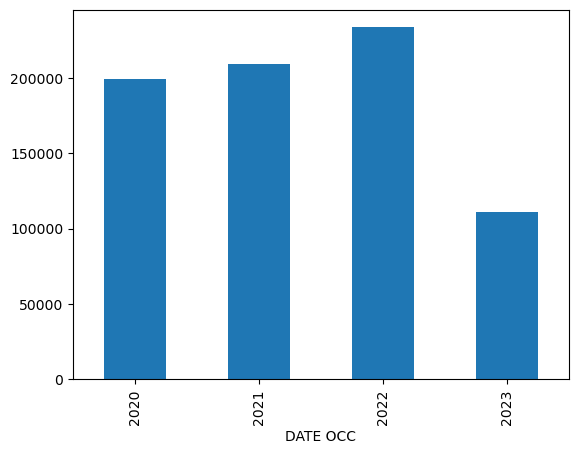

In [11]:
# not surprisingly we have an incomplete current year
df['DATE OCC'].groupby(df['DATE OCC'].dt.year).count().plot(kind='bar')

<Axes: xlabel='year'>

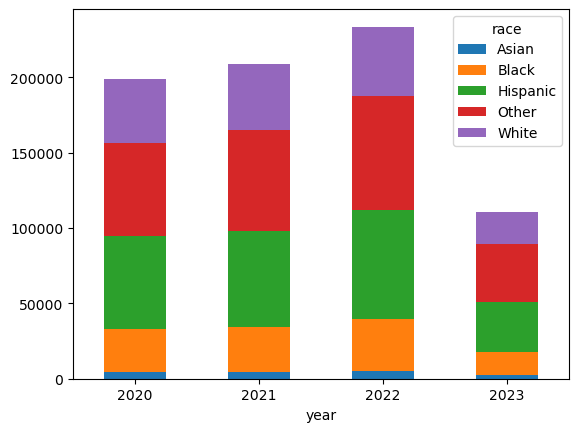

In [12]:
# is the victim's race stable year over year?
year_race_df = df[['DATE OCC', 'Vict Descent']].copy(deep=True)
year_race_df['year'] = year_race_df['DATE OCC'].dt.year
year_race_df = year_race_df.drop(columns=['DATE OCC']).rename(columns={'Vict Descent': 'race'})
year_race_df['race'] = year_race_df['race'].apply(func=lambda x: x if x in {'A', 'B', 'H', 'W'} else 
                                                  'Other').replace({'A': 'Asian', 'B': 'Black', 'H': 'Hispanic', 'W': 'White'})
year_race_df.groupby(['year', 'race']).size().unstack().plot(kind='bar', stacked=True, rot=0)

<Axes: xlabel='DATE OCC'>

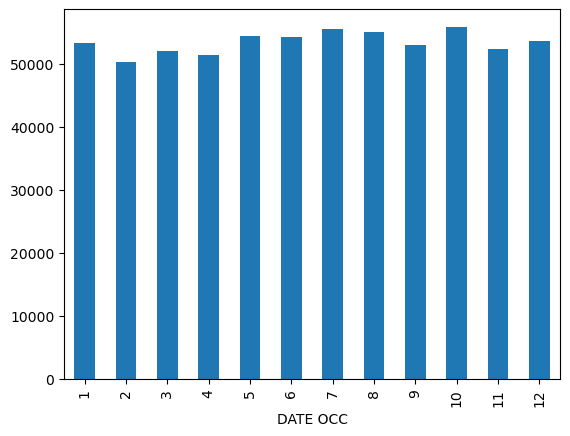

In [13]:
# where we have complete years we do not have obvious seasonality
df[df['DATE OCC'].dt.year < 2023]['DATE OCC'].groupby(df['DATE OCC'].dt.month).count().plot(kind='bar')

<Axes: xlabel='DATE OCC'>

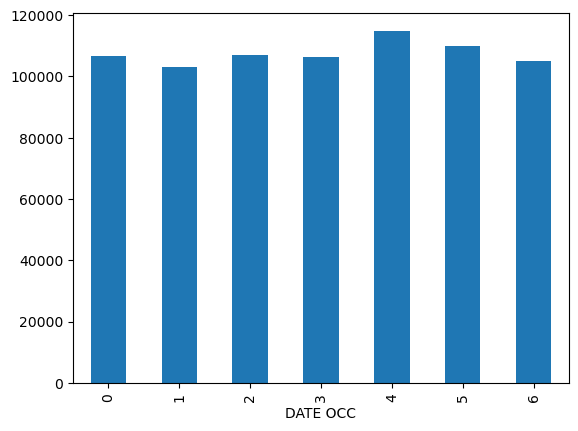

In [14]:
# nor do weekends seem to matter much
df['DATE OCC'].groupby(df['DATE OCC'].dt.dayofweek).count().plot(kind='bar')

<Axes: xlabel='DATE OCC', ylabel='Density'>

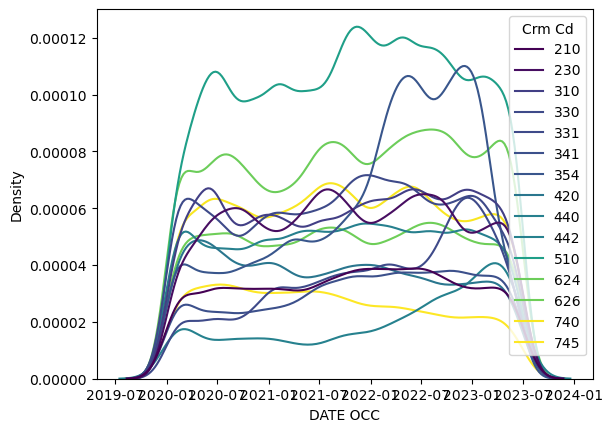

In [15]:
# if we segment by crime code do we see anything interesting?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:15].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

<Axes: xlabel='DATE OCC', ylabel='Density'>

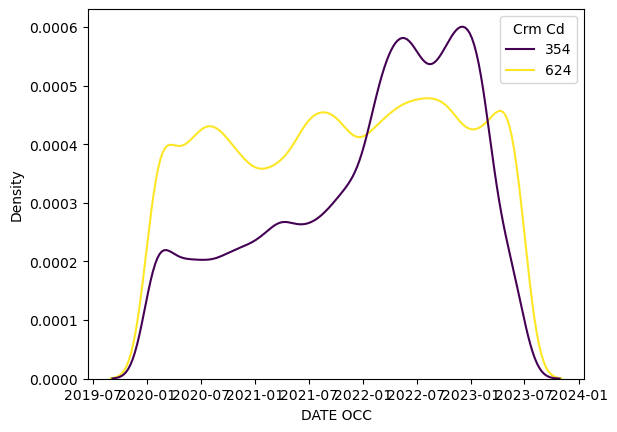

In [16]:
# we see a persistent surge in one code; which one is it?
kdeplot(data=df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[1:3].index.tolist())], x='DATE OCC', hue='Crm Cd', palette='viridis')

In [17]:
df[df['Crm Cd'].isin(df['Crm Cd'].value_counts()[:10].index.tolist())][['Crm Cd', 'Crm Cd Desc']].drop_duplicates().T

,0,4,10,15,17,18,24,30,33,45
Crm Cd,624,740,330,626,440,354,230,310,510,420
Crm Cd Desc,BATTERY - SIMPLE ASSAULT,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",BURGLARY FROM VEHICLE,INTIMATE PARTNER - SIMPLE ASSAULT,THEFT PLAIN - PETTY ($950 & UNDER),THEFT OF IDENTITY,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",BURGLARY,VEHICLE - STOLEN,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)


Identity theft seems like kind of a surprise, doesn't it?

In [18]:
# is identity theft a secular trend or is the rise concentrated in one ethnic group? 
identity_df = df[df['Crm Cd'] == 354]
identity_victim_descent = identity_df['Vict Descent'].replace(to_replace={'B': 'Black', 'H': 'Hispanic', 'W': 'White',}).value_counts()
identity_descent_df = pd.DataFrame(data={'Descent': identity_victim_descent.index, 'Count': identity_victim_descent.values}).reset_index(drop=True)
identity_descent_df.loc[identity_descent_df['Count'] < 8000, 'Descent'] = 'Other' # threshold
express.pie(identity_descent_df, names='Descent', values='Count').show()